## 0. Library Import

In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [204]:
# 출력결과 모두 확인
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1. Data 

In [205]:
ai_detect_result = pd.read_excel('./data/탐지결과_2106-2108.xlsx')
julnun_result = pd.read_excel('./data/응력완화줄눈 현황(4835)_210331.xlsx',sheet_name='응력완화줄눈 현황',skiprows = 2)

In [206]:
# 데이터 확인 
ai_detect_result.head(1)
julnun_result.head(1)

,탐지ID,탐지일시,포트홀보수일시,본부,지사,노선,방향,이정,차로,위도,경도,줄눈상태
0,6202108310078,2021-08-31 16:05:44,NaN,광주전남본부,함평지사,서해안선,서울,30.39,2차로,35.06868,126.47953,정상


,본부,지사,노선,방향,시공이정,시공년도,최초 시공폭\n(mm),줄눈폭(2020.8월말 기준)\n(mm),비고,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
ai_detect_result.info()
print()
julnun_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   탐지ID     15153 non-null  int64  
 1   탐지일시     15153 non-null  object 
 2   포트홀보수일시  0 non-null      float64
 3   본부       15153 non-null  object 
 4   지사       15153 non-null  object 
 5   노선       15153 non-null  object 
 6   방향       14875 non-null  object 
 7   이정       15153 non-null  float64
 8   차로       15153 non-null  object 
 9   위도       15153 non-null  float64
 10  경도       15153 non-null  float64
 11  줄눈상태     15153 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 1.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4836 entries, 0 to 4835
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   본부                     4835 non-null   object 
 1   지사                     4835 

# 2. Data 전처리 

*  ai 줄눈 탐지 데이터 - 차로 있는 버전

In [208]:
# 혹시 모를 사태를 대비해서 
ai_detect_result_copy = ai_detect_result.copy()

In [209]:
# ai 줄눈 탐지 데이터 - 제거 columns
'''
 탐지ID - 이미지 탐지용이므로 필요 없다고 하심
 포트홀보수일시  - 다 null 값
 줄눈 상태 - 차장님이 필요 없다고 하심
'''
ai_detect_result.drop(['탐지ID','포트홀보수일시','줄눈상태'],axis=1,inplace=True)

## 중복제거 
# 완전히 값이 같은 행 제거 
print('중복된 행개수 제거 : {0} \n 기존 행개수 :{1}'.format(ai_detect_result.drop_duplicates().shape[0],ai_detect_result.shape[0]))
ai_detect=ai_detect_result.drop_duplicates()

## 시계열적 흐름 탐지 
ai_detect['탐지일시'] = pd.to_datetime(ai_detect['탐지일시']) # 탐지일시 날짜 타입 변환
ai_detect['month'] = ai_detect['탐지일시'].dt.month # 탐지일시 month 열 추출

# 6,7,8월별 이정 기준 이동 거리 및 개수 count 하기 

ai_detect_month = ai_detect.drop_duplicates(['본부','지사','노선','방향','차로','month','이정'],keep='first')
group = ai_detect_month.groupby(['본부','지사','노선','방향','차로','month'])
group_month_distance = group['이정'].max() - group['이정'].min()
group_month_count = group['이정'].count()
ai_detect_month_final = pd.DataFrame(group_month_count.reset_index()) 
ai_detect_month_final ['월별_이정기준_이동거리'] = group_month_distance.values
ai_detect_month_final .rename(columns={'이정':'월별_이정기준_줄눈개수'},inplace=True)

## (전체) 이정 기준 이동 거리 및 개수 count 하기 

'''
가정 : (본부-지사 - 노선 - 방향 - 차로 - 이정)이 같은 것은 같은 객체를 탐지한 것으로 생각한다.

e.g) 2021.06.13일에 측정한 (서울지사 - 경부선 - 서울 - 1차로 - 31.4) 데이터  =
    2021.07.13일에 측정한 (서울지사 - 경부선 - 서울 - 1차로 - 31.4) 데이터 
'''
# (본부-지사 - 노선 - 방향 - 차로 - 이정) 같은거 중복 제거 
ai_detect_all = ai_detect.drop_duplicates(['본부','지사','노선','방향','차로','이정'],keep='first')

# 이동 거리 및 줄눈개수
group2 = ai_detect_all.groupby(['본부','지사','노선','방향','차로'])
group_distance = group2['이정'].max() - group2['이정'].min()
group_count = group2['이정'].count()
ai_detect_all_final = pd.DataFrame(group_count.reset_index()) 
ai_detect_all_final ['전체_이정기준_이동거리'] = group_distance.values
ai_detect_all_final .rename(columns={'이정':'전체_이정기준_줄눈개수'},inplace=True)

'\n 탐지ID - 이미지 탐지용이므로 필요 없다고 하심\n 포트홀보수일시  - 다 null 값\n 줄눈 상태 - 차장님이 필요 없다고 하심\n'

중복된 행개수 제거 : 14302 
 기존 행개수 :15153


<ipython-input-209-ac99a248cc04>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_detect['탐지일시'] = pd.to_datetime(ai_detect['탐지일시']) # 탐지일시 날짜 타입 변환
<ipython-input-209-ac99a248cc04>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_detect['month'] = ai_detect['탐지일시'].dt.month # 탐지일시 month 열 추출


'\n가정 : (본부-지사 - 노선 - 방향 - 차로 - 이정)이 같은 것은 같은 객체를 탐지한 것으로 생각한다.\n\ne.g) 2021.06.13일에 측정한 (서울지사 - 경부선 - 서울 - 1차로 - 31.4) 데이터  =\n    2021.07.13일에 측정한 (서울지사 - 경부선 - 서울 - 1차로 - 31.4) 데이터 \n'

In [210]:
ai_detect_all_final.head(1) # 잘 만들어진 듯 
ai_detect_month_final.head(1)

print()

ai_detect_all_final.shape, ai_detect_month_final.shape

,본부,지사,노선,방향,차로,전체_이정기준_줄눈개수,전체_이정기준_이동거리
0,강원본부,강릉지사,동해선,근덕,1차로,2,21.51


,본부,지사,노선,방향,차로,month,월별_이정기준_줄눈개수,월별_이정기준_이동거리
0,강원본부,강릉지사,동해선,근덕,1차로,6,1,0.0


((282, 7), (574, 8))

* ai 줄눈 탐지 데이터 - 차로 없는 버전

In [211]:

# 6,7,8월별 이정 기준 이동 거리 및 개수 count 하기 

ai_detect_month_차로합침 = ai_detect.drop_duplicates(['본부','지사','노선','방향','차로','month','이정'],keep='first') # 중복 자체는 모두 같아야 제거하자.
group3 = ai_detect_month_차로합침.groupby(['본부','지사','노선','방향','month'])
group_month_차로합침_distance = group3['이정'].max() - group3['이정'].min()
group_month_차로합침_count = group3['이정'].count()
ai_detect_month_차로합침_final = pd.DataFrame(group_month_차로합침_count.reset_index()) 
ai_detect_month_차로합침_final['월별_이정기준_이동거리'] = group_month_차로합침_distance.values
ai_detect_month_차로합침_final.rename(columns={'이정':'월별_이정기준_줄눈개수'},inplace=True)

## (전체) 이정 기준 이동 거리 및 개수 count 하기 

# (본부-지사 - 노선 - 방향 - 차로 - 이정) 같은거 중복 제거 
ai_detect_all_차로합침 = ai_detect.drop_duplicates(['본부','지사','노선','방향','차로','이정'],keep='first')

# 이동 거리 및 줄눈개수
group4 = ai_detect_all_차로합침.groupby(['본부','지사','노선','방향'])
group_all_차로합침_distance = group4['이정'].max() - group4['이정'].min()
grou_all_차로합침_count = group4['이정'].count()
ai_detect_all_차로합침_final = pd.DataFrame(grou_all_차로합침_count.reset_index()) 
ai_detect_all_차로합침_final['전체_이정기준_이동거리'] = group_all_차로합침_distance.values
ai_detect_all_차로합침_final.rename(columns={'이정':'전체_이정기준_줄눈개수'},inplace=True)

In [303]:
mask = ai_detect.duplicated(['본부','지사','노선','방향','차로','이정'])
df_dup = pd.concat([ai_detect, mask ], axis=1)
df_dup.rename(columns = {0 : 'Dup'}, inplace = True)

In [305]:
df_dup[df_dup['Dup']==True]

,탐지일시,본부,지사,노선,방향,이정,차로,위도,경도,month,Dup
15,2021-08-31 15:18:35,전북본부,무주지사,"통영대전선,중부선",통영,181.36,2차로,36.077408,127.540436,8,True
19,2021-08-31 15:18:33,전북본부,무주지사,"통영대전선,중부선",통영,181.42,2차로,36.077847,127.540199,8,True
24,2021-08-31 15:17:57,전북본부,무주지사,"통영대전선,중부선",통영,182.36,2차로,36.085571,127.535828,8,True
218,2021-08-31 10:30:35,전북본부,부안지사,서해안선,목포,80.05,2차로,35.466305,126.673698,8,True
244,2021-08-31 10:25:44,전북본부,부안지사,서해안선,목포,86.53,2차로,35.523998,126.686668,8,True
...,...,...,...,...,...,...,...,...,...,...,...
15122,2021-06-02 14:32:24,충북본부,제천지사,중앙선,춘천,252.17,2차로,36.942619,128.319534,6,True
15123,2021-06-02 14:31:23,충북본부,상주지사,중부내륙선,양평,166.03,2차로,36.579388,128.149399,6,True
15124,2021-06-02 14:30:12,충북본부,제천지사,중앙선,춘천,248.53,2차로,36.920986,128.348450,6,True
15125,2021-06-02 14:29:53,충북본부,상주지사,중부내륙선,양평,163.93,2차로,36.560699,128.147186,6,True


In [326]:
ai_detect[(ai_detect['본부']=='전북본부')
         &(ai_detect['지사']=='무주지사')
         &(ai_detect['노선']=='통영대전선,중부선')
         &(ai_detect['방향']=='통영')].head(1)

,탐지일시,본부,지사,노선,방향,이정,차로,위도,경도,month
10,2021-08-31 15:23:42,전북본부,무주지사,"통영대전선,중부선",통영,172.96,2차로,36.011135,127.584198,8


In [213]:
ai_detect_all_차로합침_final.rename(columns={'전체_이정기준_줄눈개수':'ai_줄눈개수','전체_이정기준_이동거리':'ai_이동거리'},inplace=True)

In [214]:
# 데이터 내보내기 
ai_detect_all_차로합침_final.to_csv('ai_detect_data.csv',index=False)

In [215]:
# 월별 확인
ai_detect_month_차로합침_final.head(2)
ai_detect_month_차로합침_final.shape

,본부,지사,노선,방향,month,월별_이정기준_줄눈개수,월별_이정기준_이동거리
0,강원본부,강릉지사,동해선,근덕,6,23,39.31
1,강원본부,강릉지사,동해선,근덕,7,4,2.37


(306, 7)

* 실제 탐지 데이터

In [289]:
real_detect = pd.read_csv('./data/응력완화줄눈현황(연결로제거).csv',encoding='cp949')

In [290]:
## 중복제거 
real_detect=real_detect.drop_duplicates()
real_detect_drop = real_detect.drop_duplicates(['본부','지사','노선','방향','시공이정'])
group5 = real_detect_drop.groupby(['본부','지사','노선','방향'])
real_distance = group5['시공이정'].max() - group5['시공이정'].min()
real_mean= group5['줄눈폭(2020.8월말 기준)\n(mm)'].mean()
real_count = group5['시공이정'].count()

real_detect_final = pd.DataFrame(real_distance.reset_index())
real_detect_final['실제_줄눈개수'] = real_count.values
real_detect_final['실제_평균줄눈폭'] = real_mean.values
real_detect_final.rename(columns={'시공이정':'실제_이동거리'},inplace=True)

In [291]:
real_detect_final.head(3)

,본부,지사,노선,방향,실제_이동거리,실제_줄눈개수,실제_평균줄눈폭
0,강원,강릉,동해선,근덕,72.49,51,36.795918
1,강원,강릉,동해선,속초,67.85,51,35.039216
2,강원,양양,동해선,삼척,1.40,3,56.666667


* 최종 데이터

In [217]:
# 데이터 불러오기
real_detect_df = pd.read_csv('real_detect_data.csv')
ai_detect_df  = pd.read_csv('ai_detect_data.csv')

In [292]:
real_detect_df = real_detect_final.copy()

명칭통일하기

In [293]:
# 명칭 통일하기
real_detect_df['본부']=real_detect_df['본부'] +'본부'
real_detect_df['지사']=real_detect_df['지사'] +'지사'

In [294]:
# 본부 찾아보기 

name_list= ['본부','지사','노선','방향']

for i in name_list:
    set_ai = set(ai_detect_df[i].unique()) - set(real_detect_df[i].unique())
    set_real = set(real_detect_df[i].unique()) - set(ai_detect_df[i].unique()) 
    
    
    print('실제 - {0} : {1}'.format(i,set_real))
    print('ai - {0} : {1}'.format(i,set_ai) )
    print()


실제 - 본부 : set()
ai - 본부 : set()

실제 - 지사 : {'동서울지사'}
ai - 지사 : {'남원지사', '청송지사', '수원지사', '대관령지사', '대전지사', '보성지사'}

실제 - 노선 : {'중앙지선', '호남선', '부산울산선', '통영대전선', '중부내륙지선', '고창담양선', '서울외곽선', '중부선', '호남지선', '제2경인선', '울산포항선', '남해선', '대남선', '청주영덕선', '대전당진선', '새만금포항선지선', '새만금포항선', '중부내륙'}
ai - 노선 : {'상주영덕선', '남해선(순천부산)', '울산선', '남해제2지선', '중부내륙선의 지선', '부산포항선', '수도권제1순환선', '호남선의 지선', '제2경인선(인천안양)', '논산천안선,호남선', '대전남부순환선', '통영대전선,중부선', '청주상주선', '남해선(영암순천)', '중앙선의 지선'}

실제 - 방향 : {'산인', '충주', '비룡', '성남', '고창', '진입', '남이', '퇴계원', '진출', '양산', ' 서울', '삼척', '담양', '연결로'}
ai - 방향 : {'언양', '산내', '영암', '안양', '이천', '함안', '상주'}



전처리 방향 - 서울 빈칸제거

In [295]:
real_detect_df[real_detect_df['방향']==' 서울'].iloc[0][3] = '서울'

* 최종 데이터

In [296]:
final_df = pd.merge(real_detect_df,ai_detect_df,on=['본부','지사','노선','방향'],how='inner')

In [297]:
# 개수 비교하기 
final_df['실제_줄눈탐지_비율'] = final_df['실제_줄눈개수']/final_df['실제_이동거리']
final_df['ai_줄눈탐지_비율'] = final_df['ai_줄눈개수']/final_df['ai_이동거리']

# 3. EDA

* 실제와의 비교 

In [368]:
final_df.head(3)

,본부,지사,노선,방향,실제_이동거리,실제_줄눈개수,실제_평균줄눈폭,ai_줄눈개수,ai_이동거리,실제_줄눈탐지_비율,ai_줄눈탐지_비율
0,강원본부,강릉지사,동해선,근덕,72.49,51,36.795918,26,39.31,0.703545,0.661409
1,강원본부,강릉지사,동해선,속초,67.85,51,35.039216,26,35.64,0.751658,0.729517
2,강원본부,원주지사,영동선,강릉,15.86,4,42.750000,32,36.97,0.252207,0.865567


In [316]:
final_df.describe()

# ai_줄눈탐지_비율이 inf인게 3개 나옴

,실제_이동거리,실제_줄눈개수,실제_평균줄눈폭,ai_줄눈개수,ai_이동거리,실제_줄눈탐지_비율,ai_줄눈탐지_비율
count,63.000000,63.000000,62.000000,63.000000,63.000000,63.000000,63.000000
mean,44.597619,44.126984,40.557144,92.984127,40.537143,inf,inf
std,24.660834,48.736451,9.193364,144.323169,25.561099,NaN,NaN
min,0.000000,1.000000,21.954545,1.000000,0.000000,0.069268,0.082759
25%,28.290000,8.500000,34.091216,6.000000,19.775000,0.367132,0.571060
50%,45.800000,24.000000,39.186047,26.000000,39.390000,0.773515,1.082183
75%,64.515000,67.000000,46.583333,104.000000,59.450000,1.343759,2.645298
max,89.100000,176.000000,64.615385,617.000000,88.850000,inf,inf


In [327]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [329]:
# 실제와 ai 상관도 분석 
final_df[['실제_줄눈개수','ai_줄눈개수','실제_줄눈탐지_비율','ai_줄눈탐지_비율']].corr()

,실제_줄눈개수,ai_줄눈개수,실제_줄눈탐지_비율,ai_줄눈탐지_비율
실제_줄눈개수,1.000000,0.890780,-0.053555,0.173099
ai_줄눈개수,0.890780,1.000000,-0.027972,0.237384
실제_줄눈탐지_비율,-0.053555,-0.027972,1.000000,0.961032
ai_줄눈탐지_비율,0.173099,0.237384,0.961032,1.000000


<AxesSubplot:>

Text(0.5, 1.0, '실제 줄눈 탐지와 ai 줄눈 탐지 간의 상관관계')

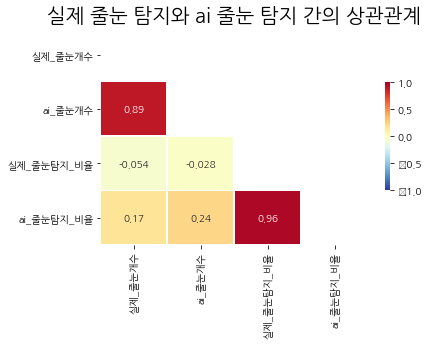

In [367]:
## 시각화 1 - Heatmap
plt.rcParams['font.family'] ='NanumGothic'
비교_corr=final_df[['실제_줄눈개수','ai_줄눈개수','실제_줄눈탐지_비율','ai_줄눈탐지_비율']].corr()

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(비교_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(비교_corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )

plt.rcParams['font.family'] ='NanumGothic'
plt.title('실제 줄눈 탐지와 ai 줄눈 탐지 간의 상관관계', fontsize=20)  
plt.show()

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, '줄눈 탐지 건수')

Text(0.5, 1.0, '실제 줄눈 탐지 건수와 ai 줄눈 탐지 건수')

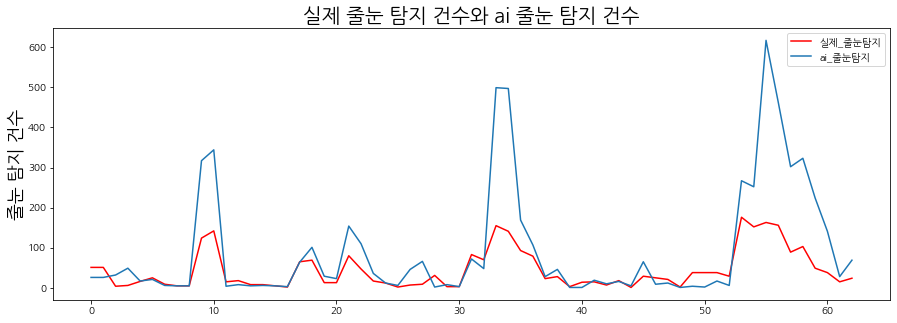

In [361]:
# 시각화1 - 선그래프

plt.rcParams['font.family'] ='NanumGothic'

#index = np.arange(len(total_df))
plt.figure(figsize=(15,5))
         
# 선그래프
plt.plot(final_df[['실제_줄눈개수']],label= '실제_줄눈탐지',color='red')
plt.plot(final_df[['ai_줄눈개수']],label= 'ai_줄눈탐지')

plt.ylabel('줄눈 탐지 건수', fontsize=18)
plt.title('실제 줄눈 탐지 건수와 ai 줄눈 탐지 건수', fontsize=20)  
plt.legend()
plt.show()

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, '줄눈탐지 비율 ')

Text(0.5, 1.0, '실제 줄눈 탐지 이동거리 대비 줄눈탐지 건수')

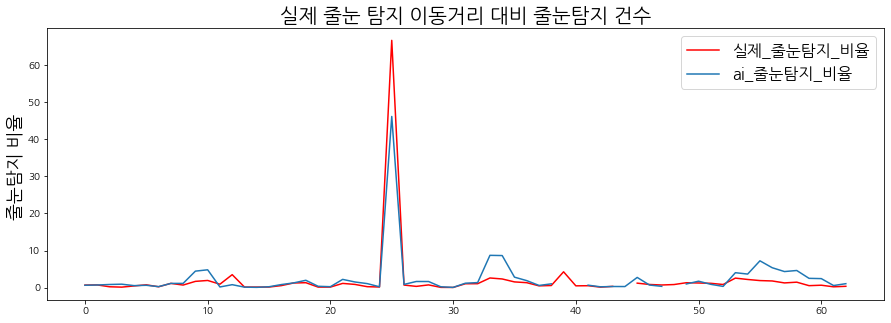

In [365]:
# 시각화1 - 선그래프

plt.rcParams['font.family'] ='NanumGothic'

#index = np.arange(len(total_df))
plt.figure(figsize=(15,5))
         
# 선그래프
plt.plot(final_df[['실제_줄눈탐지_비율']],label= '실제_줄눈탐지_비율',color='red')
plt.plot(final_df[['ai_줄눈탐지_비율']],label= 'ai_줄눈탐지_비율')
plt.ylabel('줄눈탐지 비율 ', fontsize=18)
plt.title('실제 줄눈 탐지 이동거리 대비 줄눈탐지 건수', fontsize=20)  
plt.legend()
plt.show()